In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
!git clone https://github.com/prajnasb/observations

Cloning into 'observations'...
remote: Enumerating objects: 1638, done.
remote: Total 1638 (delta 0), reused 0 (delta 0), pack-reused 1638 (from 1)
Receiving objects: 100% (1638/1638), 75.94 MiB | 11.03 MiB/s, done.
Resolving deltas: 100% (19/19), done.
Updating files: 100% (3045/3045), done.


In [3]:
data_transforms = {
    'train': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
    'test': transforms.Compose([transforms.Resize((224,224)),
                                 transforms.ToTensor()]),
}

In [4]:
data_dir = 'observations/experiements/dest_folder'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8, shuffle=True) for x in ['train', 'test']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}

class_names = image_datasets['train'].classes
print(class_names)

['with_mask', 'without_mask']


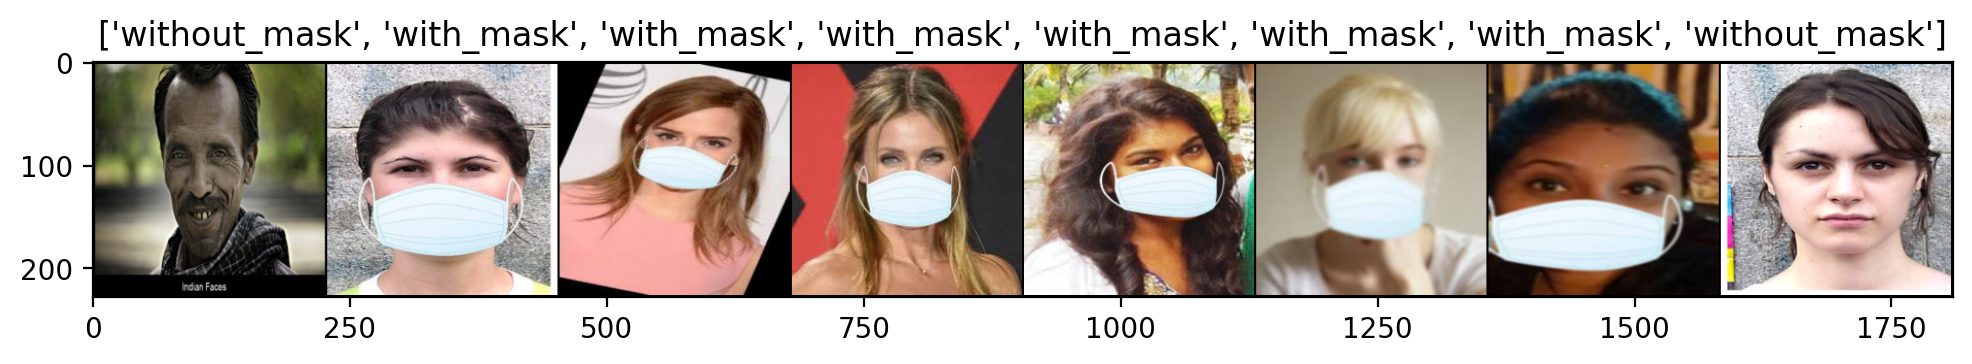

In [5]:
plt.figure(figsize=(12,8))

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# Treino com o otimizado Adam em 10 épocas

In [7]:

model = models.resnet50(pretrained=True)

for param in model.parameters():
  param.requires_grad = False


num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 2)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 36.6MB/s]


In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------
train Loss: 0.2712 Acc: 0.8875
test Loss: 0.0590 Acc: 0.9897

Epoch 1/9
----------
train Loss: 0.1181 Acc: 0.9597
test Loss: 0.0411 Acc: 0.9845

Epoch 2/9
----------
train Loss: 0.1512 Acc: 0.9361
test Loss: 0.0289 Acc: 0.9948

Epoch 3/9
----------
train Loss: 0.1220 Acc: 0.9475
test Loss: 0.0488 Acc: 0.9845

Epoch 4/9
----------
train Loss: 0.1315 Acc: 0.9475
test Loss: 0.0295 Acc: 0.9948

Epoch 5/9
----------
train Loss: 0.1015 Acc: 0.9589
test Loss: 0.0276 Acc: 0.9897

Epoch 6/9
----------
train Loss: 0.1271 Acc: 0.9521
test Loss: 0.0149 Acc: 0.9948

Epoch 7/9
----------
train Loss: 0.0726 Acc: 0.9726
test Loss: 0.0150 Acc: 0.9948

Epoch 8/9
----------
train Loss: 0.0839 Acc: 0.9688
test Loss: 0.0169 Acc: 1.0000

Epoch 9/9
----------
train Loss: 0.0576 Acc: 0.9817
test Loss: 0.0177 Acc: 1.0000

Training complete in 66m 9s
Best val Acc: 1.000000


In [8]:
torch.save(model,'sample_data/face_mask_model.pth')

In [10]:
caminho_modelo = 'sample_data/face_mask_model.pth'

modelo = torch.load(caminho_modelo)

modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

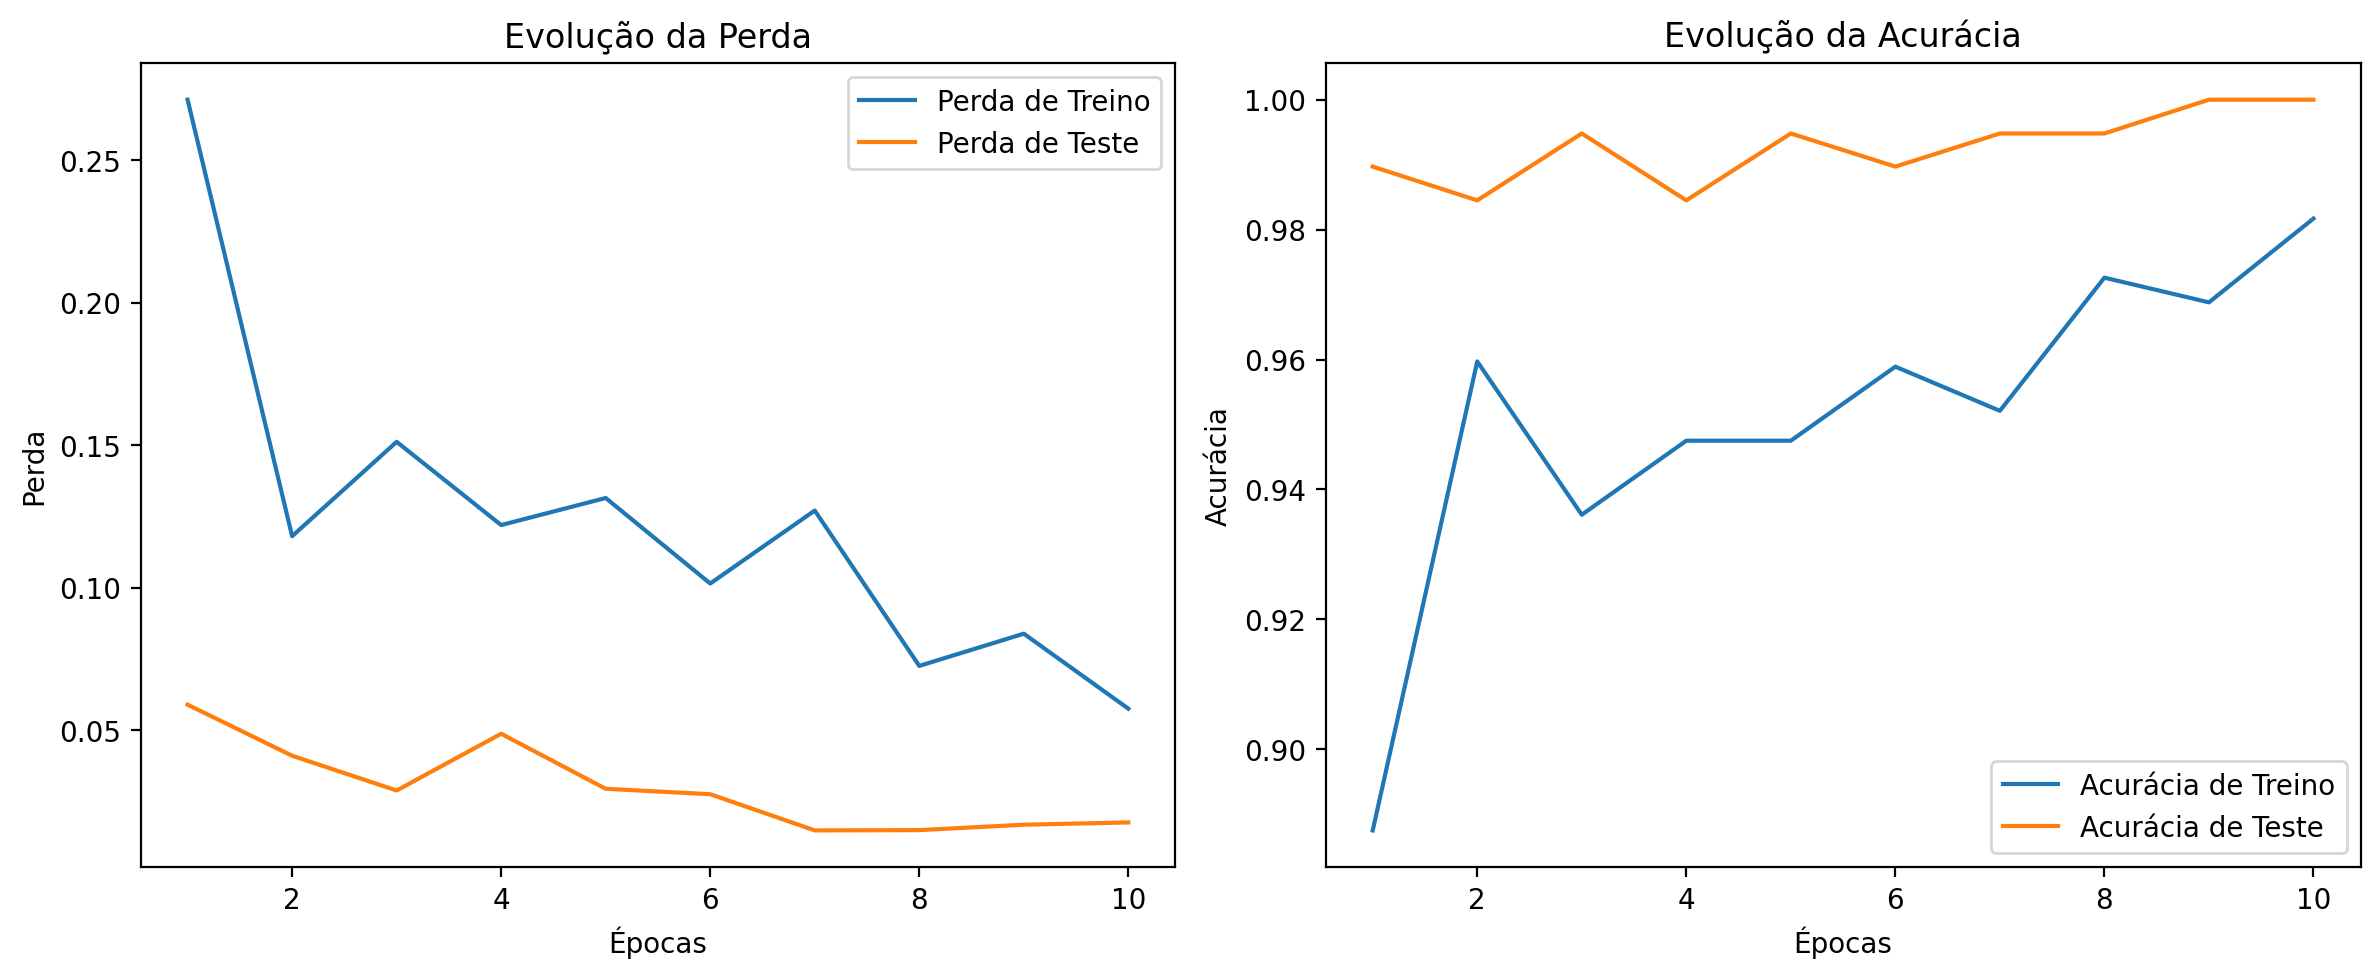

In [ ]:
epochs = range(1, 11)  # 10 épocas
train_loss = [0.2712, 0.1181, 0.1512, 0.1220, 0.1315, 0.1015, 0.1271, 0.0726, 0.0839, 0.0576]
train_acc = [0.8875, 0.9597, 0.9361, 0.9475, 0.9475, 0.9589, 0.9521, 0.9726, 0.9688, 0.9817]
test_loss = [0.0590, 0.0411, 0.0289, 0.0488, 0.0295, 0.0276, 0.0149, 0.0150, 0.0169, 0.0177]
test_acc = [0.9897, 0.9845, 0.9948, 0.9845, 0.9948, 0.9897, 0.9948, 0.9948, 1.0000, 1.0000]

# Gráfico de perda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Perda de Treino')
plt.plot(epochs, test_loss, label='Perda de Teste')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Acurácia de Treino')
plt.plot(epochs, test_acc, label='Acurácia de Teste')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:

from prettytable import PrettyTable

# Dados das épocas
epochs = range(1, 11)  # 10 épocas
train_loss = [0.2712, 0.1181, 0.1512, 0.1220, 0.1315, 0.1015, 0.1271, 0.0726, 0.0839, 0.0576]
train_acc = [0.8875, 0.9597, 0.9361, 0.9475, 0.9475, 0.9589, 0.9521, 0.9726, 0.9688, 0.9817]
test_loss = [0.0590, 0.0411, 0.0289, 0.0488, 0.0295, 0.0276, 0.0149, 0.0150, 0.0169, 0.0177]
test_acc = [0.9897, 0.9845, 0.9948, 0.9845, 0.9948, 0.9897, 0.9948, 0.9948, 1.0000, 1.0000]

# Criar a tabela
table = PrettyTable()
table.field_names = ["Época", "Perda de Treino", "Acurácia de Treino", "Perda de Teste", "Acurácia de Teste"]

for i in range(10):
    table.add_row([epochs[i], train_loss[i], train_acc[i], test_loss[i], test_acc[i]])

# Exibir a tabela
print(table)

+-------+-----------------+--------------------+----------------+-------------------+
| Época | Perda de Treino | Acurácia de Treino | Perda de Teste | Acurácia de Teste |
+-------+-----------------+--------------------+----------------+-------------------+
|   1   |      0.2712     |       0.8875       |     0.059      |       0.9897      |
|   2   |      0.1181     |       0.9597       |     0.0411     |       0.9845      |
|   3   |      0.1512     |       0.9361       |     0.0289     |       0.9948      |
|   4   |      0.122      |       0.9475       |     0.0488     |       0.9845      |
|   5   |      0.1315     |       0.9475       |     0.0295     |       0.9948      |
|   6   |      0.1015     |       0.9589       |     0.0276     |       0.9897      |
|   7   |      0.1271     |       0.9521       |     0.0149     |       0.9948      |
|   8   |      0.0726     |       0.9726       |     0.015      |       0.9948      |
|   9   |      0.0839     |       0.9688       |     0

# Treino com o otimizado Adam em 15 épocas

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------
train Loss: 0.2568 Acc: 0.9027
test Loss: 0.0522 Acc: 0.9897

Epoch 1/14
----------
train Loss: 0.1429 Acc: 0.9475
test Loss: 0.0332 Acc: 0.9897

Epoch 2/14
----------
train Loss: 0.1221 Acc: 0.9483
test Loss: 0.0622 Acc: 0.9742

Epoch 3/14
----------
train Loss: 0.1256 Acc: 0.9506
test Loss: 0.0286 Acc: 0.9948

Epoch 4/14
----------
train Loss: 0.1178 Acc: 0.9635
test Loss: 0.0137 Acc: 1.0000

Epoch 5/14
----------
train Loss: 0.1101 Acc: 0.9567
test Loss: 0.0143 Acc: 1.0000

Epoch 6/14
----------
train Loss: 0.1097 Acc: 0.9506
test Loss: 0.0193 Acc: 0.9897

Epoch 7/14
----------
train Loss: 0.0736 Acc: 0.9764
test Loss: 0.0123 Acc: 1.0000

Epoch 8/14
----------
train Loss: 0.0633 Acc: 0.9741
test Loss: 0.0158 Acc: 1.0000

Epoch 9/14
----------
train Loss: 0.0622 Acc: 0.9795
test Loss: 0.0145 Acc: 1.0000

Epoch 10/14
----------
train Loss: 0.0748 Acc: 0.9703
test Loss: 0.0134 Acc: 1.0000

Epoch 11/14
----------
train Loss: 0.0875 Acc: 0.9673
test Loss: 0.0127 Acc

In [ ]:
torch.save(model,'/content/sample_data/face_mask_model2.pth')

In [ ]:
caminho_modelo ='/content/sample_data/face_mask_model2.pth'

modelo = torch.load(caminho_modelo)

modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
from PIL import Image

In [ ]:
img_paths = [
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img1.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img2.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img3.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img4.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img5.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img6.jpeg',
    '/content/drive/MyDrive/Faculdade /QUINTO PERÍODO /Introdução a ML e Mineração de Dados/Trabalho/sprint03/pred/img7.jpeg'
]

In [ ]:
# Transformação da imagem
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Nomes das classes
class_names = ['with_mask', 'without_mask']

# Configuração do modelo
model.eval()  # Muda o modelo para modo de avaliação

# Criar subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 10))  # 2 linhas e 3 colunas
axes = axes.flatten()  # Facilita a iteração

# Loop para carregar, transformar e prever cada imagem
for i, img_path in enumerate(img_paths):
    # Carregue a imagem
    image = Image.open(img_path)

    # Aplique as transformações
    image_tensor = transform(image).unsqueeze(0)  # Adiciona uma dimensão extra para o batch

    # Realize a predição
    with torch.no_grad():  # Desativa o cálculo de gradientes
        outputs = model(image_tensor.to(device))
        _, preds = torch.max(outputs, 1)  # Obtém a classe com a maior probabilidade

    # Interprete o resultado
    predicted_class = class_names[preds.item()]

    # Exiba a imagem e a predição
    axes[i].imshow(image)
    axes[i].set_title(f'A classe predita é: {predicted_class}')
    axes[i].axis('off')  # Desliga os eixos

# Ajustar o layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


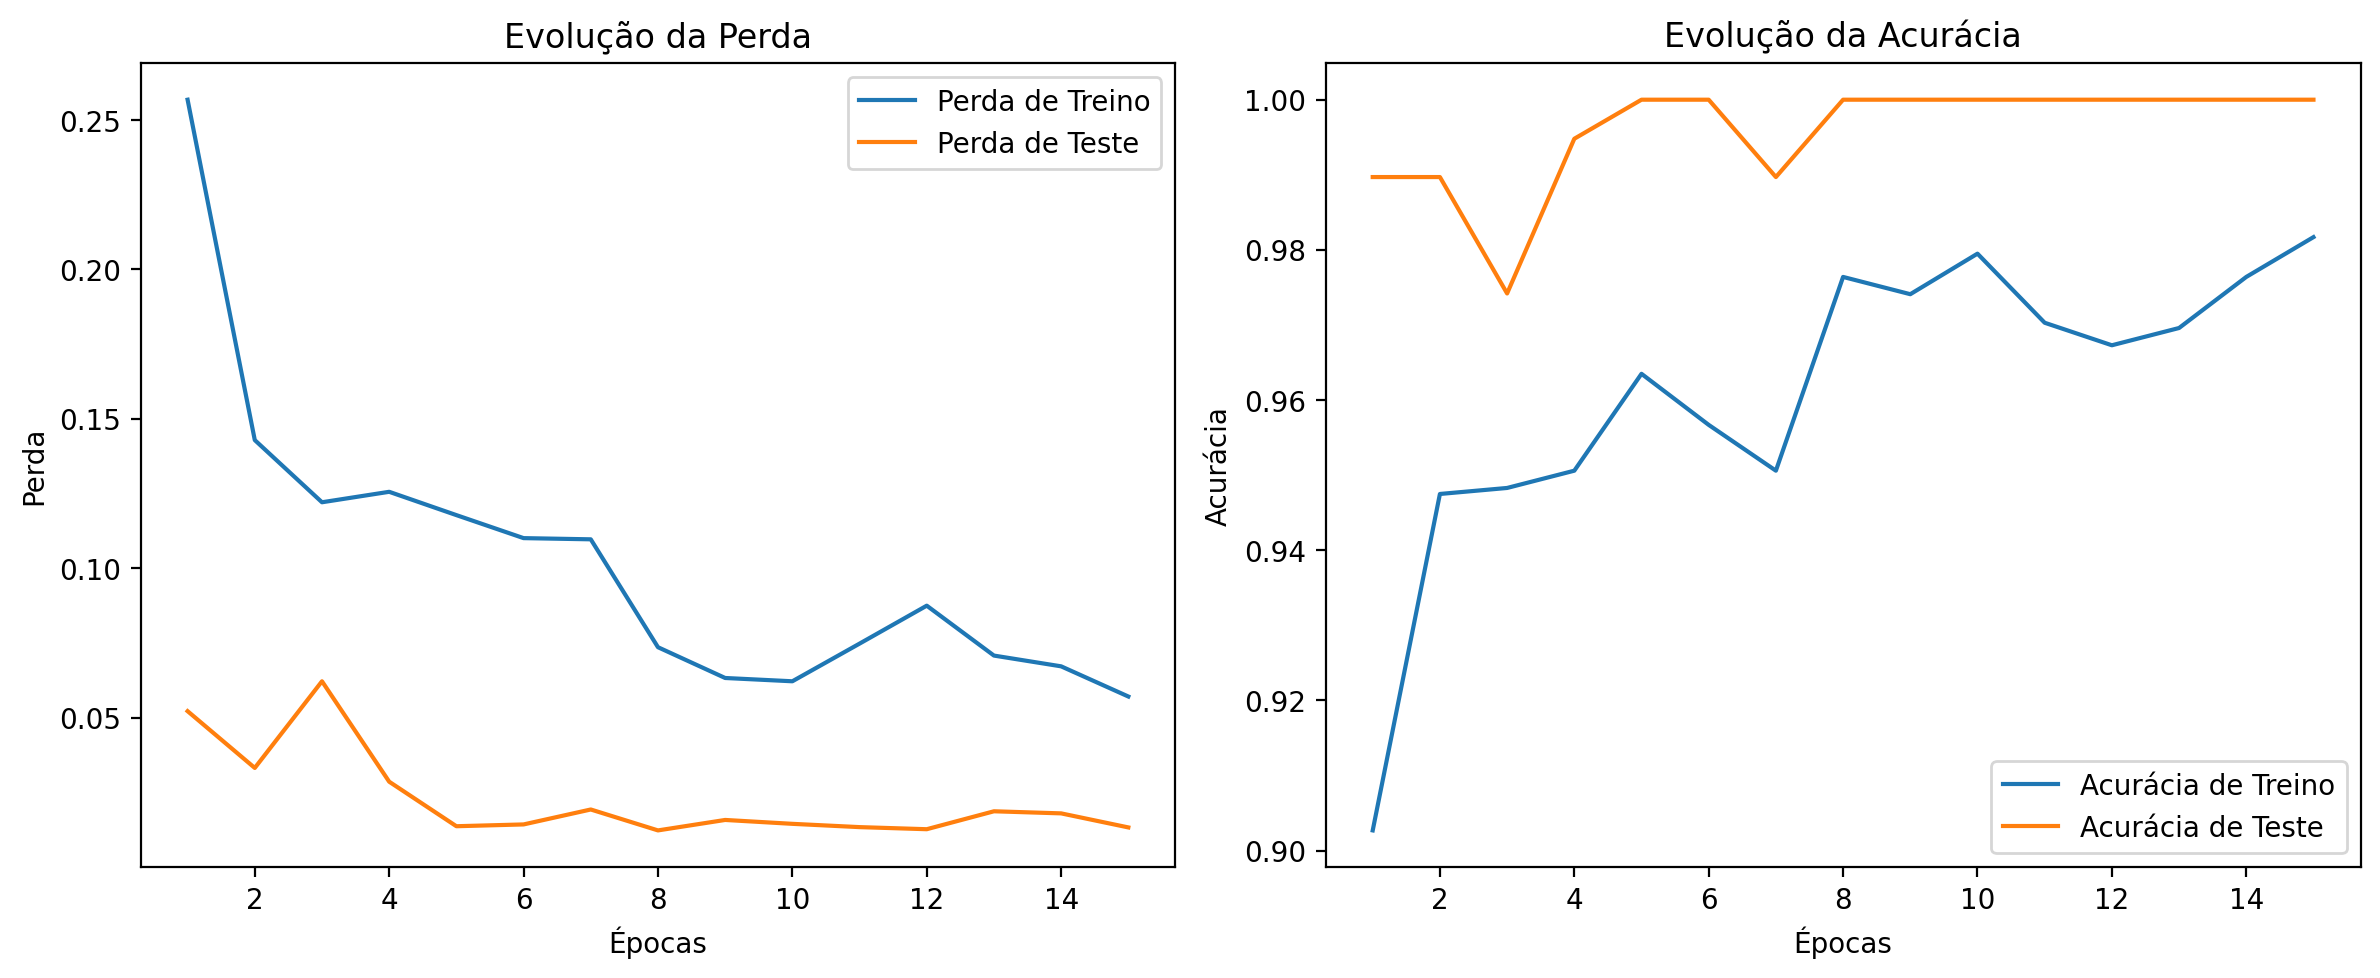

In [ ]:
epochs = range(1, 16)  # 15 épocas
train_loss = [0.2568, 0.1429, 0.1221, 0.1256, 0.1178, 0.1101, 0.1097, 0.0736, 0.0633, 0.0622, 0.0748, 0.0875, 0.0708, 0.0672, 0.0571]
train_acc = [0.9027, 0.9475, 0.9483, 0.9506, 0.9635, 0.9567, 0.9506, 0.9764, 0.9741, 0.9795, 0.9703, 0.9673, 0.9696, 0.9764, 0.9817]
test_loss = [0.0522, 0.0332, 0.0622, 0.0286, 0.0137, 0.0143, 0.0193, 0.0123, 0.0158, 0.0145, 0.0134, 0.0127, 0.0187, 0.0180, 0.0133]
test_acc = [0.9897, 0.9897, 0.9742, 0.9948, 1.0000, 1.0000, 0.9897, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

# Gráfico de perda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Perda de Treino')
plt.plot(epochs, test_loss, label='Perda de Teste')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Acurácia de Treino')
plt.plot(epochs, test_acc, label='Acurácia de Teste')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()
plt.show()

In [ ]:
from prettytable import PrettyTable

# Dados das épocas
epochs = range(1, 16)  # 15 épocas
train_loss = [0.2568, 0.1429, 0.1221, 0.1256, 0.1178, 0.1101, 0.1097, 0.0736, 0.0633, 0.0622, 0.0748, 0.0875, 0.0708, 0.0672, 0.0571]
train_acc = [0.9027, 0.9475, 0.9483, 0.9506, 0.9635, 0.9567, 0.9506, 0.9764, 0.9741, 0.9795, 0.9703, 0.9673, 0.9696, 0.9764, 0.9817]
test_loss = [0.0522, 0.0332, 0.0622, 0.0286, 0.0137, 0.0143, 0.0193, 0.0123, 0.0158, 0.0145, 0.0134, 0.0127, 0.0187, 0.0180, 0.0133]
test_acc = [0.9897, 0.9897, 0.9742, 0.9948, 1.0000, 1.0000, 0.9897, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000]

# Criar a tabela
table = PrettyTable()
table.field_names = ["Época", "Perda de Treino", "Acurácia de Treino", "Perda de Teste", "Acurácia de Teste"]

for i in range(15):
    table.add_row([epochs[i], train_loss[i], train_acc[i], test_loss[i], test_acc[i]])

# Exibir a tabela
print(table)

+-------+-----------------+--------------------+----------------+-------------------+
| Época | Perda de Treino | Acurácia de Treino | Perda de Teste | Acurácia de Teste |
+-------+-----------------+--------------------+----------------+-------------------+
|   1   |      0.2568     |       0.9027       |     0.0522     |       0.9897      |
|   2   |      0.1429     |       0.9475       |     0.0332     |       0.9897      |
|   3   |      0.1221     |       0.9483       |     0.0622     |       0.9742      |
|   4   |      0.1256     |       0.9506       |     0.0286     |       0.9948      |
|   5   |      0.1178     |       0.9635       |     0.0137     |        1.0        |
|   6   |      0.1101     |       0.9567       |     0.0143     |        1.0        |
|   7   |      0.1097     |       0.9506       |     0.0193     |       0.9897      |
|   8   |      0.0736     |       0.9764       |     0.0123     |        1.0        |
|   9   |      0.0633     |       0.9741       |     0

Treino com o otimizado Adam em 20 épocas

In [ ]:
model = train_model(model, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------
train Loss: 0.2681 Acc: 0.8897
test Loss: 0.0580 Acc: 0.9948

Epoch 1/19
----------
train Loss: 0.1636 Acc: 0.9376
test Loss: 0.0427 Acc: 0.9948

Epoch 2/19
----------
train Loss: 0.1083 Acc: 0.9612
test Loss: 0.0389 Acc: 0.9948

Epoch 3/19
----------
train Loss: 0.1315 Acc: 0.9498
test Loss: 0.0208 Acc: 1.0000

Epoch 4/19
----------
train Loss: 0.2103 Acc: 0.9262
test Loss: 0.0276 Acc: 0.9845

Epoch 5/19
----------
train Loss: 0.1145 Acc: 0.9605
test Loss: 0.0243 Acc: 0.9897

Epoch 6/19
----------
train Loss: 0.0916 Acc: 0.9627
test Loss: 0.0186 Acc: 0.9948

Epoch 7/19
----------
train Loss: 0.0788 Acc: 0.9719
test Loss: 0.0194 Acc: 0.9948

Epoch 8/19
----------
train Loss: 0.0555 Acc: 0.9779
test Loss: 0.0139 Acc: 1.0000

Epoch 9/19
----------
train Loss: 0.0895 Acc: 0.9635
test Loss: 0.0156 Acc: 1.0000

Epoch 10/19
----------
train Loss: 0.0645 Acc: 0.9764
test Loss: 0.0131 Acc: 1.0000

Epoch 11/19
----------
train Loss: 0.0725 Acc: 0.9787
test Loss: 0.0141 Acc

In [ ]:
torch.save(model,'/content/sample_data/face_mask_model3.pth')

In [ ]:
caminho_modelo = '/content/sample_data/face_mask_model3.pth'

modelo = torch.load(caminho_modelo)

modelo.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

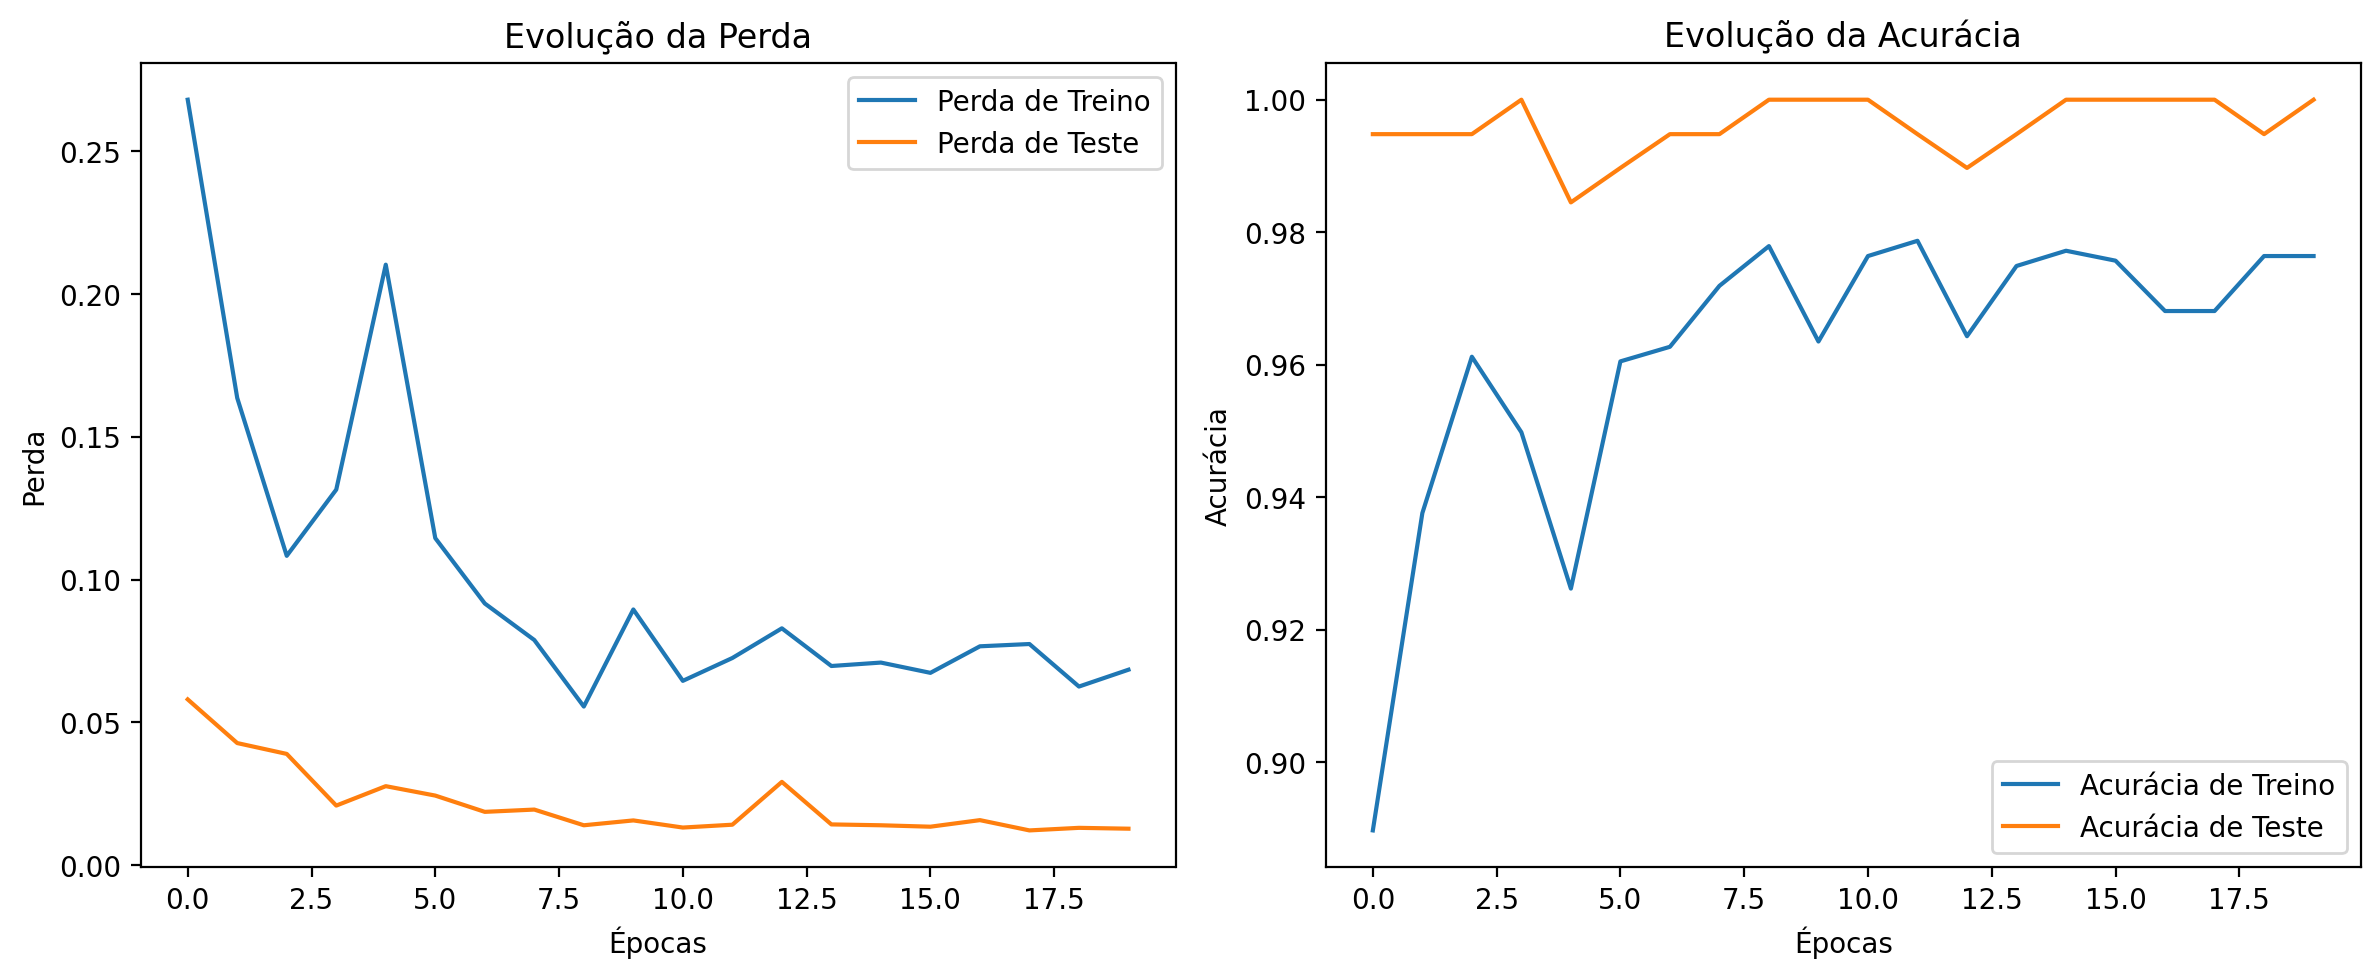

In [ ]:
epochs = range(20)  # 20 épocas
train_loss = [
    0.2681, 0.1636, 0.1083, 0.1315, 0.2103,
    0.1145, 0.0916, 0.0788, 0.0555, 0.0895,
    0.0645, 0.0725, 0.0829, 0.0697, 0.0709,
    0.0673, 0.0766, 0.0774, 0.0625, 0.0684
]
train_acc = [
    0.8897, 0.9376, 0.9612, 0.9498, 0.9262,
    0.9605, 0.9627, 0.9719, 0.9779, 0.9635,
    0.9764, 0.9787, 0.9643, 0.9749, 0.9772,
    0.9757, 0.9681, 0.9681, 0.9764, 0.9764
]
test_loss = [
    0.0580, 0.0427, 0.0389, 0.0208, 0.0276,
    0.0243, 0.0186, 0.0194, 0.0139, 0.0156,
    0.0131, 0.0141, 0.0291, 0.0142, 0.0139,
    0.0134, 0.0157, 0.0121, 0.0130, 0.0127
]
test_acc = [
    0.9948, 0.9948, 0.9948, 1.0000, 0.9845,
    0.9897, 0.9948, 0.9948, 1.0000, 1.0000,
    1.0000, 0.9948, 0.9897, 0.9948, 1.0000,
    1.0000, 1.0000, 1.0000, 0.9948, 1.0000
]

# Gráfico de perda
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Perda de Treino')
plt.plot(epochs, test_loss, label='Perda de Teste')
plt.title('Evolução da Perda')
plt.xlabel('Épocas')
plt.ylabel('Perda')
plt.legend()

# Gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Acurácia de Treino')
plt.plot(epochs, test_acc, label='Acurácia de Teste')
plt.title('Evolução da Acurácia')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
from prettytable import PrettyTable

# Dados das épocas
epochs = range(20)  # 20 épocas
train_loss = [
    0.2681, 0.1636, 0.1083, 0.1315, 0.2103,
    0.1145, 0.0916, 0.0788, 0.0555, 0.0895,
    0.0645, 0.0725, 0.0829, 0.0697, 0.0709,
    0.0673, 0.0766, 0.0774, 0.0625, 0.0684
]
train_acc = [
    0.8897, 0.9376, 0.9612, 0.9498, 0.9262,
    0.9605, 0.9627, 0.9719, 0.9779, 0.9635,
    0.9764, 0.9787, 0.9643, 0.9749, 0.9772,
    0.9757, 0.9681, 0.9681, 0.9764, 0.9764
]
test_loss = [
    0.0580, 0.0427, 0.0389, 0.0208, 0.0276,
    0.0243, 0.0186, 0.0194, 0.0139, 0.0156,
    0.0131, 0.0141, 0.0291, 0.0142, 0.0139,
    0.0134, 0.0157, 0.0121, 0.0130, 0.0127
]
test_acc = [
    0.9948, 0.9948, 0.9948, 1.0000, 0.9845,
    0.9897, 0.9948, 0.9948, 1.0000, 1.0000,
    1.0000, 0.9948, 0.9897, 0.9948, 1.0000,
    1.0000, 1.0000, 1.0000, 0.9948, 1.0000
]

# Criar a tabela
table = PrettyTable()
table.field_names = ["Época", "Perda de Treino", "Acurácia de Treino", "Perda de Teste", "Acurácia de Teste"]

for i in range(20):
    table.add_row([i, train_loss[i], train_acc[i], test_loss[i], test_acc[i]])

# Exibir a tabela
print(table)

+-------+-----------------+--------------------+----------------+-------------------+
| Época | Perda de Treino | Acurácia de Treino | Perda de Teste | Acurácia de Teste |
+-------+-----------------+--------------------+----------------+-------------------+
|   0   |      0.2681     |       0.8897       |     0.058      |       0.9948      |
|   1   |      0.1636     |       0.9376       |     0.0427     |       0.9948      |
|   2   |      0.1083     |       0.9612       |     0.0389     |       0.9948      |
|   3   |      0.1315     |       0.9498       |     0.0208     |        1.0        |
|   4   |      0.2103     |       0.9262       |     0.0276     |       0.9845      |
|   5   |      0.1145     |       0.9605       |     0.0243     |       0.9897      |
|   6   |      0.0916     |       0.9627       |     0.0186     |       0.9948      |
|   7   |      0.0788     |       0.9719       |     0.0194     |       0.9948      |
|   8   |      0.0555     |       0.9779       |     0